In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2


Cloning into 'yolov3-tf2'...


Obtaining file:///D:/Anaconda_en_DiscoD/car_plate_detection2/TFODCourse/archive/yolov3-tf2 (from -r requirements-gpu.txt (line 6))

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\javie\\appdata\\local\\continuum\\anaconda3\\envs\\tfod3\\lib\\site-packages\\~-mpy\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


In [2]:
from __future__ import division

import numpy as np

from albumentations.core.utils import DataProcessor

__all__ = [
    "normalize_bbox",
    "denormalize_bbox",
    "normalize_bboxes",
    "denormalize_bboxes",
    "calculate_bbox_area",
    "filter_bboxes_by_visibility",
    "convert_bbox_to_albumentations",
    "convert_bbox_from_albumentations",
    "convert_bboxes_to_albumentations",
    "convert_bboxes_from_albumentations",
    "check_bbox",
    "check_bboxes",
    "filter_bboxes",
    "union_of_bboxes",
    "BboxProcessor",
]


class BboxProcessor(DataProcessor):
    @property
    def default_data_name(self):
        return "bboxes"

    def ensure_data_valid(self, data):
        for data_name in self.data_fields:
            data_exists = data_name in data and len(data[data_name])
            if data_exists and len(data[data_name][0]) < 5:
                if self.params.label_fields is None:
                    raise ValueError(
                        "Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox "
                        "because bboxes must have labels"
                    )
        if self.params.label_fields:
            if not all(i in data.keys() for i in self.params.label_fields):
                raise ValueError("Your 'label_fields' are not valid - them must have same names as params in dict")

    def filter(self, data, rows, cols):
        return filter_bboxes(
            data, rows, cols, min_area=self.params.min_area, min_visibility=self.params.min_visibility
        )

    def check(self, data, rows, cols):
        return check_bboxes(data)

    def convert_from_albumentations(self, data, rows, cols):
        return convert_bboxes_from_albumentations(data, self.params.format, rows, cols, check_validity=True)

    def convert_to_albumentations(self, data, rows, cols):
        return convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=True)


def normalize_bbox(bbox, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.

    Args:
        bbox (tuple): Denormalized bounding box `(x_min, y_min, x_max, y_max)`.
        rows (int): Image height.
        cols (int): Image width.

    Returns:
        tuple: Normalized bounding box `(x_min, y_min, x_max, y_max)`.

    Raises:
        ValueError: If rows or cols is less or equal zero

    """
    (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])

    if rows <= 0:
        raise ValueError("Argument rows must be positive integer")
    if cols <= 0:
        raise ValueError("Argument cols must be positive integer")

    x_min, x_max = x_min / cols, x_max / cols
    y_min, y_max = y_min / rows, y_max / rows

    return (x_min, y_min, x_max, y_max) + tail


def denormalize_bbox(bbox, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.

    Args:
        bbox (tuple): Normalized bounding box `(x_min, y_min, x_max, y_max)`.
        rows (int): Image height.
        cols (int): Image width.

    Returns:
        tuple: Denormalized bounding box `(x_min, y_min, x_max, y_max)`.

    Raises:
        ValueError: If rows or cols is less or equal zero

    """
    (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])

    if rows <= 0:
        raise ValueError("Argument rows must be positive integer")
    if cols <= 0:
        raise ValueError("Argument cols must be positive integer")

    x_min, x_max = x_min * cols, x_max * cols
    y_min, y_max = y_min * rows, y_max * rows

    return (x_min, y_min, x_max, y_max) + tail


def normalize_bboxes(bboxes, rows, cols):
    """Normalize a list of bounding boxes.

    Args:
        bboxes (List[tuple]): Denormalized bounding boxes `[(x_min, y_min, x_max, y_max)]`.
        rows (int): Image height.
        cols (int): Image width.

    Returns:
        List[tuple]: Normalized bounding boxes `[(x_min, y_min, x_max, y_max)]`.

    """
    return [normalize_bbox(bbox, rows, cols) for bbox in bboxes]


def denormalize_bboxes(bboxes, rows, cols):
    """Denormalize a list of bounding boxes.

    Args:
        bboxes (List[tuple]): Normalized bounding boxes `[(x_min, y_min, x_max, y_max)]`.
        rows (int): Image height.
        cols (int): Image width.

    Returns:
        List[tuple]: Denormalized bounding boxes `[(x_min, y_min, x_max, y_max)]`.

    """
    return [denormalize_bbox(bbox, rows, cols) for bbox in bboxes]


def calculate_bbox_area(bbox, rows, cols):
    """Calculate the area of a bounding box in pixels.

    Args:
        bbox (tuple): A bounding box `(x_min, y_min, x_max, y_max)`.
        rows (int): Image height.
        cols (int): Image width.

    Return:
        int: Area of a bounding box in pixels.

    """
    bbox = denormalize_bbox(bbox, rows, cols)
    x_min, y_min, x_max, y_max = bbox[:4]
    area = (x_max - x_min) * (y_max - y_min)
    return area


def filter_bboxes_by_visibility(
    original_shape, bboxes, transformed_shape, transformed_bboxes, threshold=0.0, min_area=0.0
):
    """Filter bounding boxes and return only those boxes whose visibility after transformation is above
    the threshold and minimal area of bounding box in pixels is more then min_area.

    Args:
        original_shape (tuple): Original image shape `(height, width)`.
        bboxes (List[tuple]): Original bounding boxes `[(x_min, y_min, x_max, y_max)]`.
        transformed_shape (tuple): Transformed image shape `(height, width)`.
        transformed_bboxes (List[tuple]): Transformed bounding boxes `[(x_min, y_min, x_max, y_max)]`.
        threshold (float): visibility threshold. Should be a value in the range [0.0, 1.0].
        min_area (float): Minimal area threshold.

    Returns:
        List[tuple]: Filtered bounding boxes `[(x_min, y_min, x_max, y_max)]`.

    """
    img_height, img_width = original_shape[:2]
    transformed_img_height, transformed_img_width = transformed_shape[:2]

    visible_bboxes = []
    for bbox, transformed_bbox in zip(bboxes, transformed_bboxes):
        if not all(0.0 <= value <= 1.0 for value in transformed_bbox[:4]):
            continue
        bbox_area = calculate_bbox_area(bbox, img_height, img_width)
        transformed_bbox_area = calculate_bbox_area(transformed_bbox, transformed_img_height, transformed_img_width)
        if transformed_bbox_area < min_area:
            continue
        visibility = transformed_bbox_area / bbox_area
        if visibility >= threshold:
            visible_bboxes.append(transformed_bbox)
    return visible_bboxes


def convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity=False):
    """Convert a bounding box from a format specified in `source_format` to the format used by albumentations:
    normalized coordinates of top-left and bottom-right corners of the bounding box in a form of
    `(x_min, y_min, x_max, y_max)` e.g. `(0.15, 0.27, 0.67, 0.5)`.

    Args:
        bbox (tuple): A bounding box tuple.
        source_format (str): format of the bounding box. Should be 'coco', 'pascal_voc', or 'yolo'.
        check_validity (bool): Check if all boxes are valid boxes.
        rows (int): Image height.
        cols (int): Image width.

    Returns:
        tuple: A bounding box `(x_min, y_min, x_max, y_max)`.

    Note:
        The `coco` format of a bounding box looks like `(x_min, y_min, width, height)`, e.g. (97, 12, 150, 200).
        The `pascal_voc` format of a bounding box looks like `(x_min, y_min, x_max, y_max)`, e.g. (97, 12, 247, 212).
        The `yolo` format of a bounding box looks like `(x, y, width, height)`, e.g. (0.3, 0.1, 0.05, 0.07);
        where `x`, `y` coordinates of the center of the box, all values normalized to 1 by image height and width.

    Raises:
        ValueError: if `target_format` is not equal to `coco` or `pascal_voc`, ot `yolo`.
        ValueError: If in YOLO format all labels not in range (0, 1).

    """
    if source_format not in {"coco", "pascal_voc", "yolo"}:
        raise ValueError(
            "Unknown source_format {}. Supported formats are: 'coco', 'pascal_voc' and 'yolo'".format(source_format)
        )
    if isinstance(bbox, np.ndarray):
        bbox = bbox.tolist()

    if source_format == "coco":
        (x_min, y_min, width, height), tail = bbox[:4], tuple(bbox[4:])
        x_max = x_min + width
        y_max = y_min + height
    elif source_format == "yolo":
        # https://github.com/pjreddie/darknet/blob/f6d861736038da22c9eb0739dca84003c5a5e275/scripts/voc_label.py#L12
        bbox, tail = bbox[:4], tuple(bbox[4:])
        _bbox = np.array(bbox[:4])
        if check_validity and np.any((_bbox <= 0) | (_bbox > 1)):
            raise ValueError("In YOLO format all coordinates must be float and in range (0, 1]")

        x, y, w, h = bbox

        w_half, h_half = w / 2, h / 2
        x_min = x - w_half
        y_min = y - h_half
        x_max = x_min + w
        y_max = y_min + h
    else:
        (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])

    bbox = (x_min, y_min, x_max, y_max) + tail

    if source_format != "yolo":
        bbox = normalize_bbox(bbox, rows, cols)
    if check_validity:
        check_bbox(bbox)
    return bbox


def convert_bbox_from_albumentations(bbox, target_format, rows, cols, check_validity=False):
    """Convert a bounding box from the format used by albumentations to a format, specified in `target_format`.

    Args:
        bbox (tuple): An albumentation bounding box `(x_min, y_min, x_max, y_max)`.
        target_format (str): required format of the output bounding box. Should be 'coco', 'pascal_voc' or 'yolo'.
        rows (int): Image height.
        cols (int): Image width.
        check_validity (bool): Check if all boxes are valid boxes.

    Returns:
        tuple: A bounding box.

    Note:
        The `coco` format of a bounding box looks like `[x_min, y_min, width, height]`, e.g. [97, 12, 150, 200].
        The `pascal_voc` format of a bounding box looks like `[x_min, y_min, x_max, y_max]`, e.g. [97, 12, 247, 212].
        The `yolo` format of a bounding box looks like `[x, y, width, height]`, e.g. [0.3, 0.1, 0.05, 0.07].

    Raises:
        ValueError: if `target_format` is not equal to `coco`, `pascal_voc` or `yolo`.

    """
    if target_format not in {"coco", "pascal_voc", "yolo"}:
        raise ValueError(
            "Unknown target_format {}. Supported formats are: 'coco', 'pascal_voc' and 'yolo'".format(target_format)
        )
    if check_validity:
        check_bbox(bbox)

    if target_format != "yolo":
        bbox = denormalize_bbox(bbox, rows, cols)
    if target_format == "coco":
        (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])
        width = x_max - x_min
        height = y_max - y_min
        bbox = (x_min, y_min, width, height) + tail
    elif target_format == "yolo":
        (x_min, y_min, x_max, y_max), tail = bbox[:4], bbox[4:]
        x = (x_min + x_max) / 2.0
        y = (y_min + y_max) / 2.0
        w = x_max - x_min
        h = y_max - y_min
        bbox = (x, y, w, h) + tail
    return bbox


def convert_bboxes_to_albumentations(bboxes, source_format, rows, cols, check_validity=False):
    """Convert a list bounding boxes from a format specified in `source_format` to the format used by albumentations"""
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]


def convert_bboxes_from_albumentations(bboxes, target_format, rows, cols, check_validity=False):
    """Convert a list of bounding boxes from the format used by albumentations to a format, specified
    in `target_format`.

    Args:
        bboxes (List[tuple]): List of albumentation bounding box `(x_min, y_min, x_max, y_max)`.
        target_format (str): required format of the output bounding box. Should be 'coco', 'pascal_voc' or 'yolo'.
        rows (int): Image height.
        cols (int): Image width.
        check_validity (bool): Check if all boxes are valid boxes.

    Returns:
        list[tuple]: List of bounding box.

    """
    return [convert_bbox_from_albumentations(bbox, target_format, rows, cols, check_validity) for bbox in bboxes]


def check_bbox(bbox):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
    for name, value in zip(["x_min", "y_min", "x_max", "y_max"], bbox[:4]):
        if not 0 <= value <= 1 and not np.isclose(value, 0) and not np.isclose(value, 1):
            raise ValueError(
                "Expected {name} for bbox {bbox} "
                "to be in the range [0.0, 1.0], got {value}.".format(bbox=bbox, name=name, value=value)
            )
    x_min, y_min, x_max, y_max = bbox[:4]
    if x_max <= x_min:
        raise ValueError("x_max is less than or equal to x_min for bbox {bbox}.".format(bbox=bbox))
    if y_max <= y_min:
        raise ValueError("y_max is less than or equal to y_min for bbox {bbox}.".format(bbox=bbox))


def check_bboxes(bboxes):
    """Check if bboxes boundaries are in range 0, 1 and minimums are lesser then maximums"""
    for bbox in bboxes:
        check_bbox(bbox)


def filter_bboxes(bboxes, rows, cols, min_area=0.0, min_visibility=0.0):
    """Remove bounding boxes that either lie outside of the visible area by more then min_visibility
    or whose area in pixels is under the threshold set by `min_area`. Also it crops boxes to final image size.

    Args:
        bboxes (List[tuple]): List of albumentation bounding box `(x_min, y_min, x_max, y_max)`.
        rows (int): Image height.
        cols (int): Image width.
        min_area (float): Minimum area of a bounding box. All bounding boxes whose visible area in pixels.
            is less than this value will be removed. Default: 0.0.
        min_visibility (float): Minimum fraction of area for a bounding box to remain this box in list. Default: 0.0.

    Returns:
        List[tuple]: List of bounding box.

    """
    resulting_boxes = []
    for bbox in bboxes:
        transformed_box_area = calculate_bbox_area(bbox, rows, cols)
        bbox, tail = tuple(np.clip(bbox[:4], 0, 1.0)), tuple(bbox[4:])
        clipped_box_area = calculate_bbox_area(bbox, rows, cols)
        if not transformed_box_area or clipped_box_area / transformed_box_area <= min_visibility:
            continue
        else:
            bbox = tuple(np.clip(bbox[:4], 0, 1.0))
        if calculate_bbox_area(bbox, rows, cols) <= min_area:
            continue
        resulting_boxes.append(bbox + tail)
    return resulting_boxes


def union_of_bboxes(height, width, bboxes, erosion_rate=0.0):
    """Calculate union of bounding boxes.

    Args:
        height (float): Height of image or space.
        width (float): Width of image or space.
        bboxes (List[tuple]): List like bounding boxes. Format is `[(x_min, y_min, x_max, y_max)]`.
        erosion_rate (float): How much each bounding box can be shrinked, useful for erosive cropping.
            Set this in range [0, 1]. 0 will not be erosive at all, 1.0 can make any bbox to lose its volume.

    Returns:
        tuple: A bounding box `(x_min, y_min, x_max, y_max)`.

    """
    x1, y1 = width, height
    x2, y2 = 0, 0
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox[:4]
        w, h = x_max - x_min, y_max - y_min
        lim_x1, lim_y1 = x_min + erosion_rate * w, y_min + erosion_rate * h
        lim_x2, lim_y2 = x_max - erosion_rate * w, y_max - erosion_rate * h
        x1, y1 = np.min([x1, lim_x1]), np.min([y1, lim_y1])
        x2, y2 = np.max([x2, lim_x2]), np.max([y2, lim_y2])
    return x1, y1, x2, y2

In [232]:
pip install albumentations

In [31]:
%cd yolov3-tf2/
!dir

D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2
 Volume in drive D is Data
 Volume Serial Number is 72EA-58D0

 Directory of D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2

04/30/2022  01:45 AM    <DIR>          .
04/30/2022  01:45 AM    <DIR>          ..
04/30/2022  01:04 AM             2,113 .gitignore
04/30/2022  01:04 AM    <DIR>          checkpoints
04/30/2022  01:04 AM         2,509,001 colab_gpu.ipynb
04/30/2022  01:04 AM               167 conda-cpu.yml
04/30/2022  01:04 AM               209 conda-gpu.yml
04/30/2022  01:35 AM             1,390 convert.py
04/30/2022  01:04 AM    <DIR>          data
04/30/2022  01:04 AM             2,623 detect.py
04/30/2022  01:04 AM             3,037 detect_video.py
04/30/2022  01:04 AM    <DIR>          docs
04/30/2022  01:04 AM             1,089 LICENSE
04/30/2022  01:04 AM            13,145 README.md
04/30/2022  01:04 AM                68 requirements-gpu.txt
04/30/2022  01:04 AM             

In [3]:
import os
os.getcwd()

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive'

In [8]:
pip install numpy --upgrade

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\javie\\appdata\\local\\continuum\\anaconda3\\envs\\tfod3\\lib\\site-packages\\~~mpy\\.libs\\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [4]:
import tensorflow as tf
#print(tf.__version__)

In [12]:
import wget
url= 'https://pjreddie.com/media/files/darknet53.conv.74'
url='http://pjreddie.com/media/files/yolo9000.weights'
url='https://pjreddie.com/media/files/yolov3.weights'
wget.download(url)
!python D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\convert.py

100% [......................................................................] 248007048 / 248007048Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                       

2022-04-30 01:31:10.242489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-30 01:31:10.242527: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-30 01:31:14.943965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-04-30 01:31:14.944001: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 01:31:14.948473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-EODGJFJT
2022-04-30 01:31:14.948575: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-EODGJFJT
2022-04-30 01:31:14.961880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is

In [16]:
!python D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\convert.py

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

2022-04-30 01:35:40.643132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-30 01:35:40.643174: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-30 01:35:45.012045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-04-30 01:35:45.012082: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 01:35:45.016461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-EODGJFJT
2022-04-30 01:35:45.016571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-EODGJFJT
2022-04-30 01:35:45.030299: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is

                                                                                                  
Total params: 62,001,757
Trainable params: 61,949,149
Non-trainable params: 52,608
__________________________________________________________________________________________________


In [20]:
pip install yolov3

INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of keras to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of yolov3 to determine which version is compatible with other requirements. This could take a while.

The conflict is caused by:
    yolov3 1.6 depends on tensorflow==1.9.0
    yolov3 1.5 depends on opencv-python==3.4
    yolov3 1.4 depends on opencv==3.4
    yolov3 1.3 depends on opencv==3.4
    yolov3 1.2 depends on opencv==3.4
    yolov3 1.1.0 depends on opencv==3.4
    yolov3 1.0 depends on Tensorflow-gpu==1.5.0

To fix this you could try to:
1. loosen the range of package versions you've specified


ERROR: Cannot install yolov3==1.0, yolov3==1.1.0, yolov3==1.2, yolov3==1.3, yolov3==1.4, yolov3==1.5 and yolov3==1.6 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/user_guide/#fixing-conflicting-dependencies


In [5]:
# import relevant Libraries.
import sys

from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [ ]:
!pip install pyunpack
!pip install patool

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import random as rn
import patoolib
from pyunpack import Archive
import pickle
import datetime
from glob import glob
from PIL import Image

#path = os.getcwd()
#direc_train = "train"
#os.mkdir(os.path.join(os.getcwd(),'yolov3-tf2',direc_train))

In [35]:
conda install unrar

Note: you may need to restart the kernel to use updated packages.




PackagesNotFoundError: The following packages are not available from current channels:

  - unrar

Current channels:

  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.


In [36]:
# Extracting Train
patoolib.extract_archive(os.path.join(os.getcwd(),'thecarconnectionpicturedataset.rar'), outdir=os.path.join(os.getcwd(),'yolov3-tf2',direc_train))

patool: Extracting D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\thecarconnectionpicturedataset.rar ...


PatoolError: could not find an executable program to extract format rar; candidates are (rar,unrar,7z),

In [7]:
os.chdir(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive")

In [8]:
direc_train = "train"
train_path = os.path.join(os.getcwd(),'yolov3-tf2',direc_train)

data_root_train = pathlib.Path(train_path)

print(data_root_train)

D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train


In [9]:
direc_train = "train"
train_path = os.path.join(os.getcwd(),'yolov3-tf2',direc_train)

data_root_train = pathlib.Path(train_path)

print(data_root_train)

D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train


In [10]:
len(list(data_root_train.iterdir()))


64467

In [11]:
import random
all_image_paths_train = list(data_root_train.glob('*.jpg'))

all_image_paths_train = [str(path) for path in all_image_paths_train]
image_count_train = len(all_image_paths_train)
image_count_train

64467

In [12]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')



I0522 11:12:07.129934  9312 375345348.py:7] weights loaded


In [13]:
class_names = [c.strip() for c in open(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\data\coco.names').readlines()]
logging.info('classes loaded')

I0522 11:12:07.194077  9312 3421354508.py:2] classes loaded


In [94]:
all_image_paths_train[52426]

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train\\Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_OYW.jpg'

In [95]:
for i,pos in enumerate(all_image_paths_train):
    if "Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_OYW" in pos:
        print(i,pos)
    elif "Chevrolet_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_oIP" in pos:
        print(i,pos)

13569 D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train\Chevrolet_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_oIP.jpg
52426 D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train\Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_OYW.jpg


In [14]:
FLAGS.image = all_image_paths_train[0]

img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

boxes, scores, classes, nums = yolo(img)


In [15]:
boxes[0][0].numpy()

array([0.05826059, 0.07369778, 0.9185213 , 0.80442035], dtype=float32)

In [13]:
scores[0][0].numpy()


0.98554844

In [14]:

classes[0][0].numpy()


2.0

In [13]:

#print(nums[0].numpy())

all_image_paths_train[0].split('\\')[-1]

'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_aWg.jpg'

In [14]:
all_image_paths_train[0]

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train\\Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_aWg.jpg'

In [15]:
boxes[0][list(classes[0].numpy()).index(2)].numpy()

array([0.05826059, 0.07369778, 0.9185213 , 0.80442035], dtype=float32)

In [ ]:
int left  = (b.x-b.w/2.)*im.w;
int right = (b.x+b.w/2.)*im.w;
int top   = (b.y-b.h/2.)*im.h;
int bot   = (b.y+b.h/2.)*im.h;
if(left < 0) left = 0;
if(right > im.w-1) right = im.w-1;
if(top < 0) top = 0;
if(bot > im.h-1) bot = im.h-1;

In [213]:
img_raw1


<tf.Tensor: shape=(240, 320, 3), dtype=uint8, numpy=
array([[[ 97, 111, 140],
        [ 98, 112, 141],
        [101, 115, 144],
        ...,
        [173, 145, 142],
        [177, 143, 142],
        [131,  95,  95]],

       [[ 95, 109, 138],
        [ 96, 110, 139],
        [ 98, 112, 141],
        ...,
        [174, 146, 143],
        [172, 141, 139],
        [114,  80,  79]],

       [[ 93, 107, 136],
        [ 94, 108, 137],
        [ 96, 110, 139],
        ...,
        [171, 145, 144],
        [170, 140, 140],
        [112,  80,  81]],

       ...,

       [[140, 149, 178],
        [145, 154, 183],
        [150, 159, 188],
        ...,
        [231, 227, 224],
        [230, 226, 223],
        [228, 224, 221]],

       [[144, 151, 179],
        [145, 152, 180],
        [147, 154, 182],
        ...,
        [230, 226, 225],
        [229, 225, 224],
        [227, 223, 222]],

       [[147, 154, 182],
        [140, 147, 175],
        [133, 140, 168],
        ...,
        [224, 220, 21

In [245]:
bbox_pr=tuple([0.01968029, 0.21669176, 0.9616722 , 0.74860597])
type(bbox_pr)
t = bbox_pr
#bbox_pr=tuple([round(x,4) if isinstance(x, float) else x for x in t])

In [246]:
bbox_pr

(0.01968029, 0.21669176, 0.9616722, 0.74860597)

In [247]:
convert_bbox_from_albumentations(bbox_pr, 'pascal_voc', 240, 320, check_validity=False)

(6.2976928, 52.006022400000006, 307.735104, 179.6654328)

In [252]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier
t = (6.2976928, 52.006022400000006, 307.735104, 179.6654328)
tuple([round(truncate(x)) if isinstance(x, float) else x for x in t])

(6, 52, 307, 179)

In [259]:
bbox_real1=[]
for i,pos in tqdm(enumerate(df_total['bbox'].values.tolist())):
    bbox_pr=tuple(pos)
    stp1=convert_bbox_from_albumentations(bbox_pr, 'pascal_voc', 240, 320, check_validity=False)
    bbox1_real.append(list(tuple([round(truncate(x)) if isinstance(x, float) else x for x in stp1])))

13225it [00:00, 78995.13it/s]


In [262]:
bbox_real[10842]

[1, 42, 306, 189]

In [159]:
import glob
files12=glob.glob('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\*.jpg')
for i,pos in enumerate(files12):
    os.rename(pos,pos.replace(".jpg","&%")+str(i+1)+".jpg")

['D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2024_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_OCZ.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2028_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_gvL.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2029_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_Idt.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2030_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_GYH.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2033_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_QEs.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TF

In [30]:
len(bbox_vavacars)

4518

In [43]:
paths[1043].split("_")[5].split("\\")[-1]

'Ford$MPV'

In [9]:
import random
import string
def random_char(y):
       return ''.join(random.choice(string.ascii_letters) for x in range(y))
print (random_char(3))

brn


In [282]:
files12=glob.glob('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\*.jpg')
bbox_vavacars=[]
paths=[]
modeloss=[]
for i,pos in tqdm(enumerate(files12[:11])):
    print(pos)

11it [00:00, ?it/s]

D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\Alfa Romeo Giulietta Hatchback 2015_16960.jpg
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\Alfa Romeo Giulietta Hatchback 2015_16966.jpg
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\Alfa Romeo Giulietta Hatchback 2016_14000.jpg
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\Alfa Romeo Giulietta Hatchback 2016_14006.jpg
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\Alfa Romeo Giulietta Hatchback 2017_17240.jpg
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\Alfa Romeo Giulietta Hatchback 2017_17246.jpg
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\Alfa Romeo Giulietta Hatchback 2020_11928.jpg
D:\Ana

In [298]:
filesbc=glob.glob(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\*.jpg')
filesbc[-1].replace(filesbc[-1].split("\\")[-1],'DH.jpg')

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\DH.jpg'

In [310]:
print(newruta,oldruta)

D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\ D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\


In [324]:
files12=glob.glob('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\*.jpg')
files21=glob.glob('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\*.xml')
files21bueno=[]
files12bueno=[]
for i,pos in enumerate(files12):
    files12bueno.append(pos.replace(".jpg",""))
for i,pos in enumerate(files21):
    files21bueno.append(pos.replace(".xml",""))

In [334]:
len(modeloss)

14970

In [332]:
import pandas as pd
import numpy as np
import random
import xml.etree.ElementTree as ET
antiguinombre=[]
nombrenuevo=[]
from tqdm import tqdm
files12=glob.glob('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\*.jpg')
bbox_vavacars=[]
paths=[]
modeloss=[]
for i,pos in tqdm(enumerate(files12)):
    
    name=pos.replace(".jpg",".xml")
    tree =ET.parse(name)
    root = tree.getroot()#chanelaz
    modelo=root.find('.//object//name').text
    xmin=int(root.find('.//object//bndbox//xmin').text)
    xmax=int(root.find('.//object//bndbox//xmax').text)
    ymin=int(root.find('.//object//bndbox//ymin').text)
    ymax=int(root.find('.//object//bndbox//ymax').text)
    modeloss.append(modelo)
    bbox_vavacars.append([xmin,ymin,xmax,ymax])
    ruta='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\'
    modelo=modelo+'_Corvette_'+str(np.random.randint(2000,2999,size=1)[0])+'_'+str(np.random.randint(11,99,size=1)[0])+'_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_'+random_char(3)
    paths.append(ruta+modelo+'.jpg')
    antiguinombre.append(files12[i])
    nombrenuevo.append(paths[i].replace(oldruta,newruta))
    os.rename(files12[i],paths[i].replace(oldruta,newruta))


14970it [03:16, 76.19it/s]


In [395]:
files12[i]

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\Alfa Romeo Giulietta Hatchback 2015_2.jpg'

In [396]:
import pandas as pd
import numpy as np
import random
import xml.etree.ElementTree as ET
antiguinombre1=[]
nombrenuevo1=[]
from tqdm import tqdm
files12=glob.glob('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\*.jpg')
bbox_vavacars1=[]
paths1=[]
modeloss1=[]
for i,pos in tqdm(enumerate(files12)):
    
    name=pos.replace(".jpg",".xml")
    tree =ET.parse(name)
    root = tree.getroot()#chanelaz
    modelo=root.find('.//object//name').text
    xmin=int(root.find('.//object//bndbox//xmin').text)
    xmax=int(root.find('.//object//bndbox//xmax').text)
    ymin=int(root.find('.//object//bndbox//ymin').text)
    ymax=int(root.find('.//object//bndbox//ymax').text)
    modeloss1.append(modelo)
    bbox_vavacars1.append([xmin,ymin,xmax,ymax])
    ruta='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\'
    modelo=modelo+'_Corvette_'+str(np.random.randint(2000,2999,size=1)[0])+'_'+str(np.random.randint(11,99,size=1)[0])+'_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_'+random_char(3)
    paths1.append(ruta+modelo+'.jpg')
    antiguinombre1.append(files12[i])
    nombrenuevo1.append(paths1[i].replace(oldruta,newruta))
    os.rename(files12[i],paths1[i].replace(oldruta,newruta))


2882it [00:35, 80.50it/s]


In [406]:
muestra2.to_csv('muestra1.csv',index=False)

In [402]:
muestra1 = pd.DataFrame(
    {'antiguinombre1': antiguinombre1,
     'nombrenuevo1': nombrenuevo1,
    })#crear dataframe

muestra2 = pd.DataFrame(
    {'antiguinombre1': antiguinombre,
     'nombrenuevo1': nombrenuevo,
    })#crear dataframe

In [410]:
paths[1032]

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\Ford$Focus$Hatchback_Corvette_2328_87_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_JQV.jpg'

In [416]:
bbox_vavacars=bbox_vavacars1[:1]*len(files)
bbox_vavacars

[[63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909,

In [12]:
import glob
files=glob.glob(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\*.jpg')
#print(len(bbox_vavacars))
len(files)

17640

In [284]:
import os
removing_files = glob.glob(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\*.jpg')
for i in removing_files:
    os.remove(i)


In [179]:
import shutil
files=glob.glob(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\Tensorflow\workspace\images\train_reduced\*.jpg')

for i,pos in tqdm(enumerate(files)):
                shutil.copy(pos, r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars')


4518it [00:35, 127.28it/s]


In [182]:
oldruta='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\'
newruta='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\'
paths_vavacars=[]
for i in paths:
    paths_vavacars.append(i.replace(oldruta,newruta))

In [183]:
paths_vavacars

['D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2051_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_Waj.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2043_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_TcA.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2082_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_rqm.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2046_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_DAj.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Hatchback_Corvette_2060_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_oxw.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TF

In [124]:
erroees

[]

In [184]:
bbox_vavacars

[[136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],
 [136, 328, 5859, 3701],
 [113, 367, 5871, 3490],


In [338]:
paths[327]


'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\Fiat$Egea$Sedan_Corvette_2211_35_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_drc.jpg'

In [339]:
files[327]

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Fiat$Egea$Sedan_Corvette_2623_50_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_AQo.jpg'

In [187]:
print(set(heights1))
set(widths1)

{4000}


{6000}

In [185]:
import PIL 
from tqdm import tqdm
widths1=[]
heights1=[]
files12=glob.glob(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\*.jpg')

for i,pos in tqdm(enumerate(files12[:5008])):
    image = PIL.Image.open(pos)

    width, height = image.size
    heights1.append(height)
    widths1.append(width)

4518it [00:42, 107.09it/s]


In [208]:
FLAGS.image = 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train\\'+'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_aWg.jpg'

img_raw1 = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
img1 = tf.expand_dims(img_raw1, 0)
img1 = transform_images(img1, FLAGS.size)

boxes1, scores1, classes1, nums1 = yolo(img1)
if list(classes1[0].numpy()).count(2) == 1 and scores1[0][list(classes1[0].numpy()).index(2)] > 0.99:
    bbox_pr=boxes1[0][list(classes1[0].numpy()).index(2)].numpy()
    print("IN")

In [102]:
from tqdm import tqdm
bbox_copia = []
image = []
for i in tqdm(range(len(all_image_paths_train))):

  FLAGS.image = all_image_paths_train[i]

  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  boxes, scores, classes, nums = yolo(img)

  if list(classes[0].numpy()).count(2) == 1 and scores[0][list(classes[0].numpy()).index(2)] > 0.99:
    bbox_copia.append(boxes[0][list(classes[0].numpy()).index(2)].numpy())
    image.append(FLAGS.image.split('\\')[-1])

100%|█████████████████████████████████████████████████████████████████████████| 64467/64467 [20:07:59<00:00,  1.12s/it]


In [105]:
len(image)

13225

In [28]:
FLAGS.num_classes

80

In [29]:
FLAGS.weights

'./checkpoints/yolov3.tf'

In [45]:
logging

<module 'absl.logging' from 'C:\\Users\\javie\\AppData\\Local\\Continuum\\anaconda3\\envs\\tfod3\\lib\\site-packages\\absl\\logging\\__init__.py'>

In [14]:
from absl import logging
import numpy as np
import tensorflow as tf
import cv2
from seaborn import color_palette
from PIL import Image, ImageDraw, ImageFont
def draw_outputs1(img, outputs, class_names):
    colors = ((np.array(color_palette("hls", 80)) * 255)).astype(np.uint8)
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(font='C:/Windows' + "/fonts/arial.ttf",
                              size=(img.size[0] + img.size[1]) // 100)
    for i in range(nums):
        color = colors[int(classes[i])]
        x1y1 = ((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = ((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        thickness = (img.size[0] + img.size[1]) // 200
        x0, y0 = x1y1[0], x1y1[1]
        for t in np.linspace(0, 1, thickness):
            x1y1[0], x1y1[1] = x1y1[0] - t, x1y1[1] - t
            x2y2[0], x2y2[1] = x2y2[0] - t, x2y2[1] - t
            draw.rectangle([x1y1[0], x1y1[1], x2y2[0], x2y2[1]], outline=tuple(color))
        confidence = '{:.2f}%'.format(objectness[i]*100)
        text = '{} {}'.format(class_names[int(classes[i])], confidence)
        text_size = draw.textsize(text, font=font)
        draw.rectangle([x0, y0 - text_size[1], x0 + text_size[0], y0],
                        fill=tuple(color))
        draw.text((x0, y0 - text_size[1]), text, fill='black',
                              font=font)
    rgb_img = img.convert('RGB')
    img_np = np.asarray(rgb_img)
    img = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

    return img
#draw_outputs1(img, (boxes, scores, classes, nums), class_names)

I0516 13:26:14.989366 14176 1988221091.py:10] weights loaded
I0516 13:26:14.989366 14176 1988221091.py:13] classes loaded
I0516 13:26:15.951558 14176 1988221091.py:24] time: 0.8954873085021973
I0516 13:26:15.967182 14176 1988221091.py:26] detections:
I0516 13:26:15.971130 14176 1988221091.py:30] 	car, 0.9966800808906555, [0.26270664 0.34669653 0.40587908 0.5401914 ]
I0516 13:26:15.971130 14176 1988221091.py:30] 	bus, 0.9952293634414673, [0.32288754 0.15145977 0.6138201  0.506682  ]
I0516 13:26:15.971130 14176 1988221091.py:30] 	bus, 0.9951196312904358, [0.67014587 0.17855006 0.9937171  0.5290145 ]
I0516 13:26:15.971130 14176 1988221091.py:30] 	person, 0.9875381588935852, [0.6138846  0.34505442 0.6877058  0.7753    ]
I0516 13:26:15.986764 14176 1988221091.py:30] 	person, 0.9875274896621704, [0.6745359  0.36693054 0.76731586 0.80656105]
I0516 13:26:15.986764 14176 1988221091.py:30] 	person, 0.9751366376876831, [0.22922698 0.34322938 0.26619264 0.52385163]
I0516 13:26:15.986764 14176 1988

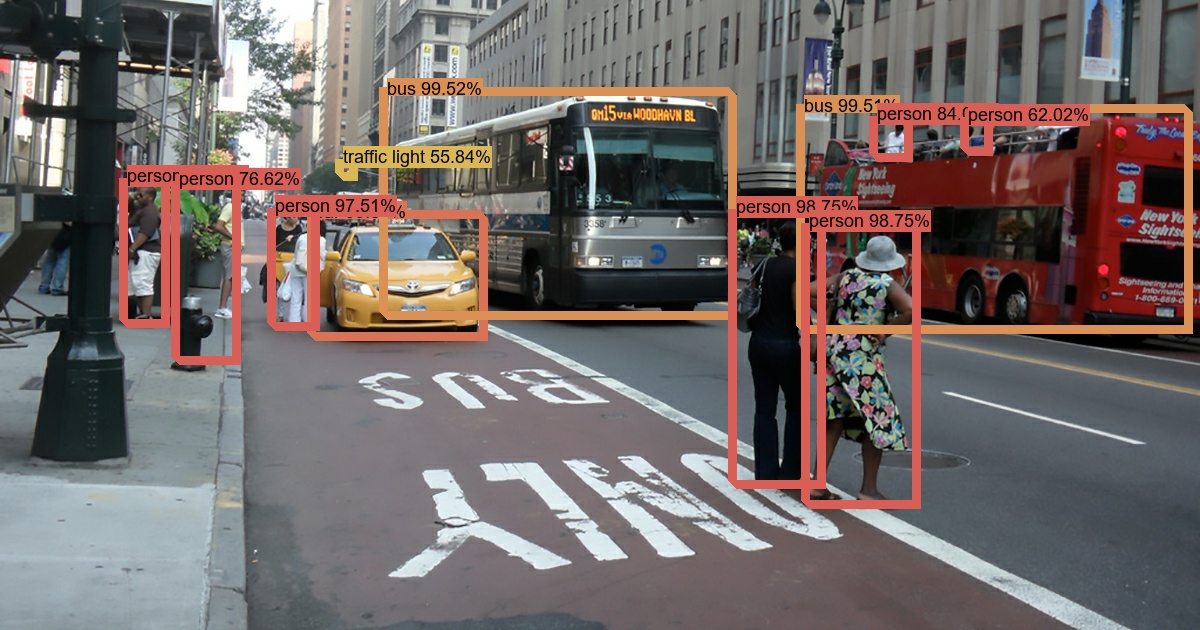

In [17]:
# sample Image detection.
FLAGS.image = r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\data\street.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\data\coco.names').readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))
    
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)

img = draw_outputs1(img, (boxes, scores, classes, nums), class_names)


from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

I0430 23:27:02.245083  9196 2957892628.py:10] weights loaded
I0430 23:27:02.254278  9196 2957892628.py:13] classes loaded
I0430 23:27:03.504945  9196 2957892628.py:24] time: 1.1661593914031982
I0430 23:27:03.511912  9196 2957892628.py:26] detections:
I0430 23:27:03.517597  9196 2957892628.py:30] 	person, 0.9997696876525879, [0.06754467 0.03718692 0.967988   0.96507543]
I0430 23:27:03.520914  9196 2957892628.py:30] 	chair, 0.9267330169677734, [0.01851873 0.34200278 0.17385134 0.6278329 ]


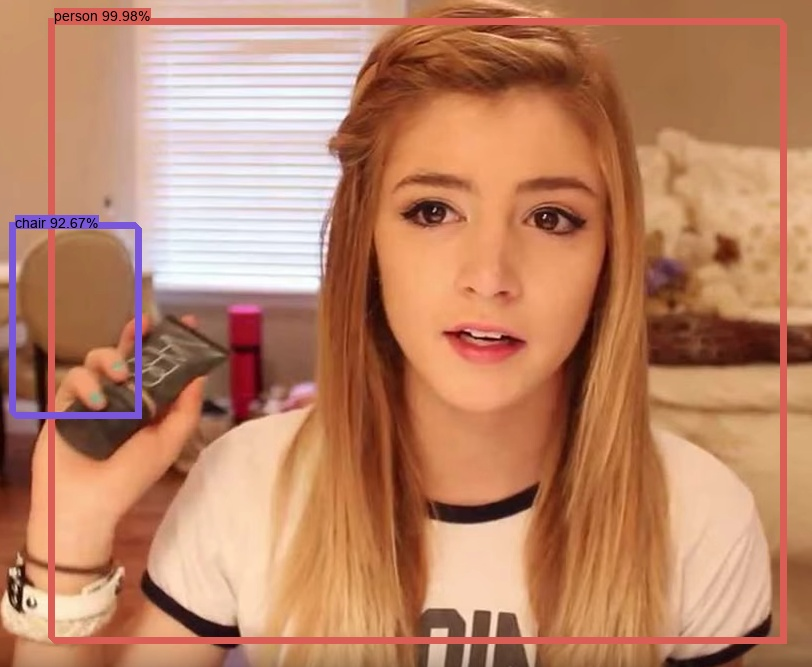

In [79]:
# sample Image detection.
FLAGS.image = r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\data\girl.png'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\data\coco.names').readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))
    
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)

img = draw_outputs1(img, (boxes, scores, classes, nums), class_names)


from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

In [341]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
save_object(df_total, 'all_info_37590_70126_V6.pkl')

NameError: name 'df_total' is not defined

In [89]:
import itertools
new_bbox=[]
for i,pos in enumerate(bbox):
    new_bbox.append(pos.tolist())
#new_bbox = list(itertools.chain.from_iterable(new_bbox))
new_bbox

[[0.03144031763076782,
  0.2845410704612732,
  0.971002995967865,
  0.6817895174026489],
 [0.051487863063812256,
  0.05384933948516846,
  0.957522451877594,
  0.8267446160316467],
 [0.1570279896259308,
  0.36073586344718933,
  0.7793192863464355,
  0.7686512470245361],
 [0.1363562047481537,
  0.1427864134311676,
  0.8744096755981445,
  0.6659723520278931],
 [0.045919209718704224,
  0.30643871426582336,
  0.9340555667877197,
  0.6580638885498047],
 [0.07510828971862793, 0.0, 0.9740160703659058, 0.8986079692840576],
 [0.027161359786987305,
  0.15467646718025208,
  0.9651626348495483,
  0.7451238632202148],
 [0.06616222858428955,
  0.18274512887001038,
  0.9392200708389282,
  0.7252689599990845],
 [0.13484534621238708,
  0.3761345446109772,
  0.8497052192687988,
  0.729926347732544],
 [0.13523945212364197,
  0.14254987239837646,
  0.8724327087402344,
  0.6681416034698486],
 [0.06982371211051941,
  0.43285083770751953,
  0.9219698905944824,
  0.8542819023132324],
 [0.14916443824768066,
  0

In [90]:
len(new_bbox)

13225

In [95]:
set(image)

{'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_aWg.jpg'}

In [29]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)


In [113]:
bbox_copia[897]==bbox[897]

array([ True,  True,  True,  True])

In [116]:
import itertools
new_bbox=[]
for i,pos in enumerate(bbox_copia):
    new_bbox.append(pos.tolist())
#new_bbox = list(itertools.chain.from_iterable(new_bbox))
new_bbox

[[0.03144031763076782,
  0.2845410704612732,
  0.971002995967865,
  0.6817895174026489],
 [0.051487863063812256,
  0.05384933948516846,
  0.957522451877594,
  0.8267446160316467],
 [0.1570279896259308,
  0.36073586344718933,
  0.7793192863464355,
  0.7686512470245361],
 [0.1363562047481537,
  0.1427864134311676,
  0.8744096755981445,
  0.6659723520278931],
 [0.045919209718704224,
  0.30643871426582336,
  0.9340555667877197,
  0.6580638885498047],
 [0.07510828971862793, 0.0, 0.9740160703659058, 0.8986079692840576],
 [0.027161359786987305,
  0.15467646718025208,
  0.9651626348495483,
  0.7451238632202148],
 [0.06616222858428955,
  0.18274512887001038,
  0.9392200708389282,
  0.7252689599990845],
 [0.13484534621238708,
  0.3761345446109772,
  0.8497052192687988,
  0.729926347732544],
 [0.13523945212364197,
  0.14254987239837646,
  0.8724327087402344,
  0.6681416034698486],
 [0.06982371211051941,
  0.43285083770751953,
  0.9219698905944824,
  0.8542819023132324],
 [0.14916443824768066,
  0

In [343]:
train_path = os.getcwd()+"\\Train"
test_path = os.getcwd()+"\\Test"

data_root_train = pathlib.Path(train_path)
data_root_test = pathlib.Path(test_path)

print(data_root_train)
print(data_root_test)

D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\checkpoints\Train
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\checkpoints\Test


In [29]:
len(list(data_root_train.iterdir()))+ \
len(list(data_root_test.iterdir()))

0

In [30]:
pip install pickle5

In [12]:
import pickle5 as pickle
with open('bboxes.pkl', 'rb') as inp:
    df4 = pickle.load(inp)
df4

,bbox
0,"[232, 140, 5840, 3894]"
1,"[232, 140, 5840, 3894]"
2,"[232, 140, 5840, 3894]"
3,"[232, 140, 5840, 3894]"
4,"[232, 140, 5840, 3894]"
...,...
2219,"[232, 140, 5840, 3894]"
2220,"[232, 140, 5840, 3894]"
2221,"[232, 140, 5840, 3894]"
2222,"[232, 140, 5840, 3894]"


In [13]:
import pickle5 as pickle
with open('paths.pkl', 'rb') as inp:
    images = pickle.load(inp)
images

['D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_Uqr.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_HVX.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_pqj.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_ClN.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_XNE.jpg',


In [17]:
bbox_vavacars=[[63, 186, 5909, 3801]]*17604
bbox_vavacars

[[63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909, 3801],
 [63, 186, 5909,

In [12]:
df4 = pd.DataFrame(
    {'bbox': bbox_vavacars,
    })#crear dataframe
df4

,bbox
0,"[63, 186, 5909, 3801]"
1,"[63, 186, 5909, 3801]"
2,"[63, 186, 5909, 3801]"
3,"[63, 186, 5909, 3801]"
4,"[63, 186, 5909, 3801]"
...,...
17601,"[63, 186, 5909, 3801]"
17602,"[63, 186, 5909, 3801]"
17603,"[63, 186, 5909, 3801]"
17604,"[63, 186, 5909, 3801]"


In [15]:
import glob
files=glob.glob(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars1\*.jpg')

images=files

In [16]:
len(images)

17604

In [114]:
save_object(bbox_copia, 'bboxk1.pkl')

In [202]:
save_object(images, 'paths_vavacars.pkl')

In [13]:
import shutil
import xml.etree.ElementTree as ET



In [140]:
train1=r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train1"
for i,pos in enumerate(image):
    if pos in files:
        shutil.copy(pos, train1)

In [46]:
## train y test split

In [18]:
# Libraries
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


In [15]:
car_bbox = list(df4['bbox'])
car_bbox[620]

[63, 186, 5909, 3801]

In [19]:
images==files

True

In [19]:
len(car_image_paths)

17606

In [27]:
len(car_image_paths)

17640

In [20]:
car_image_paths=[]
for i,pos in enumerate(images):
    car_image_paths.append(pos.replace("D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\",""))

In [21]:
car_image_paths[11490]

'Renault$Clio$Hatchback_Corvette_2911_18_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_UbO.jpg'

In [18]:
list(range(1,11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [22]:

print(car_image_paths[620])
car_bbox = list(df4['bbox'])
car_bbox[620]

Audi$A4$Sedan_Corvette_2063_39_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_fTo.jpg


NameError: name 'df4' is not defined

In [ ]:
# Write a function to crop the images to the sizes of the bounding box. reusmarco
from tqdm import tqdm
for i in tqdm(range(11491,len(car_bbox))):
    
    im = Image.open(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\\"+car_image_paths[i])
    
    #bbox = (car_bbox[i][0], car_bbox[i][1] ,car_bbox[i][2],car_bbox[i][3])
    #im = im.crop(bbox)

    new_image = im.resize((600, 400))
    new_image.save(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars1\\"+car_image_paths[i])

  7%|█████▋                                                                         | 444/6149 [03:24<43:10,  2.20it/s]

In [23]:
# Get all the images.
import glob 
#os.chdir(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\\")
files = glob.glob(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars1\\"+'*.jpg')
#files = np.random.permutation(files)
print("Number of files in Train Data:",len(files))



Number of files in Train Data: 17604


In [19]:
files

['D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_ClN.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_HVX.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_iqd.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_OIH.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_pqj.j

In [24]:
# Loadign images.
# Step :1
images = []
errores=[]
# load image and convert to and from NumPy array 
from PIL import Image 
from numpy import asarray
# load the image

for i in tqdm(files[:]):
    try:
        
        images.append(np.array(Image.open(i)))
    except:
        errores.append(i)

100%|████████████████████████████████████████████████████████████████████████████| 17604/17604 [05:17<00:00, 55.48it/s]


In [24]:
len(images[0])

400

In [51]:
pos

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Volvo$XC60$SUV_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_APw.jpg'

In [48]:
for i,pos in tqdm(enumerate(files)):

    image = Image.open(pos)
    new_image = image.resize((600, 400))
    new_image.save(pos)

2224it [26:29,  1.40it/s]


In [21]:
df4['bbox']

0       [232, 140, 5840, 3894]
1       [232, 140, 5840, 3894]
2       [232, 140, 5840, 3894]
3       [232, 140, 5840, 3894]
4       [232, 140, 5840, 3894]
                 ...          
2219    [232, 140, 5840, 3894]
2220    [232, 140, 5840, 3894]
2221    [232, 140, 5840, 3894]
2222    [232, 140, 5840, 3894]
2223    [232, 140, 5840, 3894]
Name: bbox, Length: 2224, dtype: object

In [30]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

save_object(images, 'images_2.pkl')

MemoryError: 

In [77]:
images

['D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2072_82_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_Phd.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2133_13_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_TnG.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2192_31_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_zEz.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2213_88_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_bAx.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\Alfa$Romeo$Giulietta$Hatchback_Corvette_2217_46_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_coo.j

In [25]:
data = []
for i in files:
    data.append(i.replace('detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars1\\',"").split("_")[4:])
# Loadign images.
# Step :1
#images = []
#for i in tqdm(files):
#    images.append(np.array(Image.open(i)))
data[1]

['Alfa$Romeo$Giulietta$Hatchback',
 'Corvette',
 '2133',
 '13',
 '18',
 '450',
 '62',
 '8',
 '73',
 '48',
 '176',
 '17',
 'RWD',
 '2',
 '2',
 'Convertible',
 'TnG.jpg']

In [208]:
images[1]

array([[[207, 207, 209],
        [207, 207, 209],
        [207, 207, 209],
        ...,
        [193, 193, 195],
        [193, 193, 195],
        [193, 193, 195]],

       [[207, 207, 209],
        [207, 207, 209],
        [207, 207, 209],
        ...,
        [193, 193, 195],
        [193, 193, 195],
        [193, 193, 195]],

       [[207, 207, 209],
        [207, 207, 209],
        [207, 207, 209],
        ...,
        [193, 193, 195],
        [193, 193, 195],
        [193, 193, 195]],

       ...,

       [[163, 163, 161],
        [163, 163, 161],
        [163, 163, 161],
        ...,
        [ 67,  68,  63],
        [ 75,  76,  71],
        [ 82,  83,  78]],

       [[163, 163, 161],
        [163, 163, 161],
        [163, 163, 161],
        ...,
        [ 92,  93,  88],
        [111, 112, 107],
        [124, 125, 120]],

       [[163, 163, 161],
        [163, 163, 161],
        [163, 163, 161],
        ...,
        [123, 124, 119],
        [130, 131, 126],
        [134, 135, 130]]

In [90]:
data[1]

['Alfa$Romeo$Giulietta$Hatchback',
 'Corvette',
 '2133',
 '13',
 '18',
 '450',
 '62',
 '8',
 '73',
 '48',
 '176',
 '17',
 'RWD',
 '2',
 '2',
 'Convertible',
 'TnG.jpg']

In [26]:
print(len(data[0]))

project_data = pd.DataFrame(data, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'])
project_data['images'] = images
len(project_data['1'].value_counts())

17


280

In [26]:
project_data.iloc[[19]]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,images
19,Audi$A1$Hatchback,Corvette,2327,60,18,450,62,8,73,48,176,17,RWD,2,2,Convertible,rLN.jpg,"[[[223, 222, 228], [223, 222, 228], [223, 222,..."


In [27]:
coches=project_data.groupby(["1"]).size().reset_index(name='Count')
coches.sort_values(by=["Count"],ascending=True)

,1,Count
279,Volvo$XC60$SUV,2
107,Hyundai$Ix35$Hatchback,2
59,Dacia$Sandero$Stepway$Hatchback,2
187,Opel$Vectra$Sedan,2
186,Opel$Mokka$X$SUV,2
...,...,...
209,Renault$Megane$Sedan,631
265,Volkswagen$Passat$Sedan,698
253,Toyota$Corolla$Sedan,702
93,Honda$Civic$Sedan,874


In [28]:
project_data1 = project_data[~project_data['1'].isin(coches[coches['Count']<40]['1'].values.tolist())]
#project_data1

In [33]:
len(valid_index)

4710

In [32]:
makessofar=[]#checkpoint
valid_index=[]
other_valid_index=[]
for i,pos in enumerate(project_data1['1']):
    if makessofar.count(pos)<60:
        makessofar.append(pos)
        valid_ids=True
        if valid_ids==True:
                    valid_index.append(i)
        else:
                    other_valid_index.append(i)

In [34]:
project_data1.iloc[valid_index].groupby(["1"]).size().reset_index(name='Count').sort_values(by=["Count"],ascending=False)#['Count'].mean()

,1,Count
0,Audi$A3$Hatchback,60
60,Renault$Kadjar$SUV,60
57,Renault$Clio$Hatchback,60
56,Renault$Captur$SUV,60
55,Peugeot$308$Hatchback,60
...,...,...
15,Fiat$500L$MPV,40
50,Opel$Mokka$SUV,40
32,Hyundai$Kona$SUV,40
34,Jeep$Renegade$SUV,40


In [35]:
# Train and test split :
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(project_data1.iloc[valid_index], test_size = 0.19, stratify = project_data1.iloc[valid_index]['1'])
print(len(X_train))
print(len(X_test))

X_train = X_train.reset_index()
X_test = X_test.reset_index()

3815
895


In [36]:
X_train.groupby(["1"]).size().reset_index(name='Count').sort_values(by=["Count"],ascending=False)

,1,Count
0,Audi$A3$Hatchback,49
53,Peugeot$3008$SUV,49
33,Hyundai$Tucson$SUV,49
37,Kia$Sportage$SUV,49
39,Mercedes-Benz$A$Hatchback,49
...,...,...
50,Opel$Mokka$SUV,32
15,Fiat$500L$MPV,32
34,Jeep$Renegade$SUV,32
19,Ford$EcoSport$SUV,32


In [37]:
os.chdir(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\train")
# Step : 2
j=[]
for i in tqdm(range(len(X_train))):
    im = Image.fromarray(X_train['images'][i])
    im.save(X_train['1'][i]+ '_' +  X_train['2'][i] + '_' + X_train['3'][i] + '_' + X_train['4'][i] + '_' + X_train['5'][i] +  '_' + X_train['6'][i] + '_' + X_train['7'][i] +'_' + X_train['8'][i] +'_' + X_train['9'][i] + '_' +X_train['10'][i] + '_' + X_train['11'][i] + '_' +X_train['12'][i] + '_' + X_train['13'][i] + '_' +X_train['14'][i] +'_' + X_train['15'][i] + '_' + X_train['16'][i] + '_' +  X_train['17'][i])    
    j.append((X_train['1'][i]+ '_' +  X_train['2'][i] + '_' + X_train['3'][i] + '_' + X_train['4'][i] + '_' + X_train['5'][i] +  '_' + X_train['6'][i] + '_' + X_train['7'][i] +'_' + X_train['8'][i] +'_' + X_train['9'][i] + '_' +X_train['10'][i] + '_' + X_train['11'][i] + '_' +X_train['12'][i] + '_' + X_train['13'][i] + '_' +X_train['14'][i] +'_' + X_train['15'][i] + '_' + X_train['16'][i] + '_' +  X_train['17'][i])    )

100%|██████████████████████████████████████████████████████████████████████████████| 3815/3815 [00:45<00:00, 83.30it/s]


In [38]:
os.chdir(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\test")
# Step : 2
for i in tqdm(range(len(X_test))):
    im = Image.fromarray(X_test['images'][i])
    im.save(X_test['1'][i]+ '_' +  X_test['2'][i] + '_' + X_test['3'][i] + '_' + X_test['4'][i] + '_' + X_test['5'][i] +  '_' + X_test['6'][i] + '_' + X_test['7'][i] +'_' + X_test['8'][i] +'_' + X_test['9'][i] + '_' +X_test['10'][i] + '_' + X_test['11'][i] + '_' +X_test['12'][i] + '_' + X_test['13'][i] + '_' +X_test['14'][i] +'_' + X_test['15'][i] + '_' + X_test['16'][i] + '_' +  X_test['17'][i])    


100%|████████████████████████████████████████████████████████████████████████████████| 895/895 [00:10<00:00, 89.11it/s]


In [39]:
train_val = X_train['1'].value_counts().values
test_val = X_test['1'].value_counts().values


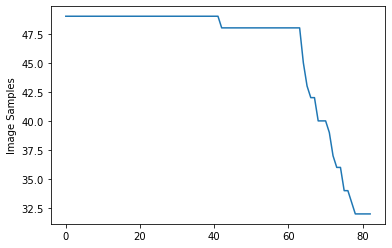

In [40]:
plt.plot(train_val)
plt.ylabel('Image Samples')
plt.show()

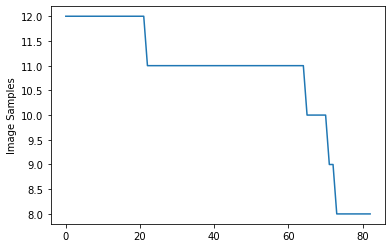

In [41]:
plt.plot(test_val)
plt.ylabel('Image Samples')
plt.show()

In [42]:
train_path = r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\train"
test_path = r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\test"

data_root_train = pathlib.Path(train_path)
data_root_test = pathlib.Path(test_path)

print(data_root_train)
print(data_root_test)

len(list(data_root_train.iterdir()))+ \
len(list(data_root_test.iterdir()))


D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\train
D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments\test


4710

In [43]:
import random
all_image_paths_train = list(data_root_train.glob('*.jpg'))
all_image_paths_test = list(data_root_test.glob('*.jpg'))

all_image_paths_train = [str(path) for path in all_image_paths_train]
all_image_paths_test = [str(path) for path in all_image_paths_test]
all_image_paths_test[:5]

['D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Audi$A3$Hatchback_Corvette_2005_49_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_KeX.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Audi$A3$Hatchback_Corvette_2030_98_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_MCD.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Audi$A3$Hatchback_Corvette_2052_78_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_pHI.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Audi$A3$Hatchback_Corvette_2072_34_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_esV.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Audi$A3$Hatchback_Corvette_2099_46_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_DpN.jpg']

In [44]:
random.shuffle(all_image_paths_train)
random.shuffle(all_image_paths_test)

image_count_train = len(all_image_paths_train)
image_count_test = len(all_image_paths_test)

image_count_train+image_count_test

4710

In [45]:
#List the available labels
label_names_train = sorted(item.name.split("_")[0] for item in data_root_train.glob('*/'))
label_names_test = sorted(item.name.split("_")[0] for item in data_root_test.glob('*/'))
# Get Unique labels.
def unique(list1): 
    # intilize a null list 
    unique_list = [] 
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    return unique_list
label_names_train = unique(label_names_train)
label_names_test = unique(label_names_test)
label_names_train[:5]

['Audi$A3$Hatchback',
 'Audi$A3$Sedan',
 'Audi$A4$Sedan',
 'Audi$Q2$SUV',
 'Audi$Q3$SUV']

In [46]:
print("Total Number of labels in Train: ",len(label_names_train))
print("Total Number of labels in Test: ",len(label_names_test))

Total Number of labels in Train:  83
Total Number of labels in Test:  83


In [47]:
label_to_index_train = dict((name, index) for index,name in enumerate(label_names_train))
label_to_index_test = dict((name, index) for index,name in enumerate(label_names_test))
all_image_labels_train = [label_to_index_train[pathlib.Path(path).name.split('_')[0]]
                    for path in all_image_paths_train]
all_image_labels_test = [label_to_index_test[pathlib.Path(path).name.split('_')[0]]
                    for path in all_image_paths_test]
all_image_labels_train

[80,
 45,
 52,
 34,
 46,
 11,
 82,
 48,
 44,
 43,
 48,
 51,
 51,
 23,
 70,
 48,
 53,
 31,
 30,
 39,
 31,
 10,
 36,
 36,
 41,
 47,
 73,
 42,
 32,
 12,
 7,
 72,
 19,
 35,
 64,
 78,
 52,
 54,
 51,
 58,
 44,
 80,
 53,
 57,
 64,
 31,
 61,
 64,
 76,
 57,
 43,
 47,
 54,
 29,
 41,
 12,
 39,
 63,
 10,
 16,
 58,
 79,
 59,
 57,
 10,
 24,
 50,
 53,
 77,
 30,
 77,
 22,
 5,
 12,
 52,
 67,
 10,
 53,
 82,
 52,
 81,
 9,
 9,
 6,
 74,
 71,
 64,
 20,
 51,
 47,
 75,
 68,
 65,
 56,
 77,
 76,
 40,
 18,
 11,
 65,
 2,
 31,
 52,
 27,
 16,
 61,
 1,
 57,
 45,
 60,
 76,
 36,
 68,
 46,
 25,
 27,
 62,
 51,
 64,
 72,
 10,
 29,
 79,
 59,
 63,
 46,
 41,
 57,
 43,
 13,
 53,
 16,
 71,
 44,
 66,
 56,
 31,
 36,
 39,
 37,
 6,
 38,
 18,
 33,
 59,
 0,
 3,
 66,
 31,
 62,
 68,
 6,
 29,
 10,
 14,
 82,
 43,
 41,
 65,
 30,
 1,
 17,
 71,
 21,
 11,
 30,
 58,
 61,
 70,
 34,
 82,
 70,
 29,
 77,
 4,
 79,
 73,
 62,
 17,
 39,
 79,
 25,
 40,
 69,
 56,
 72,
 71,
 6,
 19,
 33,
 46,
 5,
 57,
 27,
 22,
 16,
 76,
 27,
 23,
 52,
 34,
 7,
 46,
 

In [48]:
print(len(all_image_labels_train),len(all_image_labels_test))
len(all_image_labels_train) + len(all_image_labels_test)

3815 895


4710

In [49]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)
tf.random.set_seed(123)
a = tf.random.uniform([1])
a[0].numpy()

0.12615311

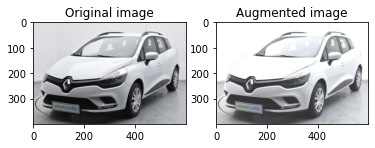

In [50]:
image_string = tf.io.read_file(all_image_paths_train[60])
image = tf.image.decode_jpeg(image_string, channels=3)
flipped = tf.image.random_brightness(image, max_delta = 0.2)

visualize(image, flipped)

In [51]:
dataset_size = len(all_image_paths_train)
dataset_size


3815

In [52]:
def tfdata_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, label):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        image = tf.image.flip_left_right(image)

        image = tf.image.random_brightness(image, max_delta = 0.4)
        image = tf.image.central_crop(image, central_fraction=0.8)

        image = tf.cast(image,dtype=tf.float32)
        image = tf.keras.applications.mobilenet.preprocess_input(image)

        #resize the image
        image = tf.image.resize(image, [224, 224])

        #one hot coding for label
        y = tf.one_hot(tf.cast(label, tf.uint8), 41)
        return image, y
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
      dataset = dataset.shuffle(10580)  # depends on sample size
      dataset = dataset.repeat()

    
    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size,num_parallel_batches=4))
  
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [87]:
all_image_paths_train

['D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\train\\Volkswagen$Passat$Variant$Station$wagon_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_Tlb.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\train\\Opel$Grandland$X$SUV_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_PuD.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\train\\Ford$EcoSport$SUV_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_uPE.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\train\\BMW$4$Serisi$Coupe_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_nHR.jpg',
 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\train\\Seat$Arona$SUV_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_EGg.jpg',
 '

In [53]:
#creating a generator
train_dataset = tfdata_generator(all_image_paths_train, all_image_labels_train, is_training=True, batch_size=100)
#creating a generator
test_dataset = tfdata_generator(all_image_paths_test, all_image_labels_test, is_training=False, batch_size=100)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


W0522 11:30:01.442195  9312 deprecation.py:343] From C:\Users\javie\AppData\Local\Temp/ipykernel_7792/3127535091.py:33: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [54]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D, Add
from tensorflow.keras import regularizers, optimizers, Model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),alpha = .5,
                                               include_top=False, 
                                               weights='imagenet')

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
prediction_layer = tf.keras.layers.Dense(41, activation='softmax')(x)

learning_rate = 0.00001

model=Model(inputs=base_model.input,outputs=prediction_layer)

for layer in model.layers[:80]:
    layer.trainable=False
for layer in model.layers[80:]:
    layer.trainable=True

opt=tf.keras.optimizers.Adam(lr=learning_rate,clipnorm=0.001)

C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
iterator = iter(train_dataset)
ckpt = tf.train.Checkpoint( step = tf.Variable(1), optimizer = opt, net = model, iterator = iterator)
manager = tf.train.CheckpointManager(ckpt, directory = 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\checkpoints', max_to_keep = 3)

In [56]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\logs\\' + current_time + '\\train'
test_log_dir = 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\logs\\' + current_time + '\\test'

In [57]:
@tf.function
def train_step(model, batch, optimizer):
  """ Trains model on batch using optimizer """
  with tf.GradientTape() as tape:
    y_ = model(batch[0], training= True)
    loss = tf.keras.losses.categorical_crossentropy(y_true = batch[1], y_pred= y_)
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    logits = model(batch[0], training=True)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(batch[1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return loss, accuracy 
@tf.function
def loss_fn(model, images, labels):
  logits = model(images, training=False)
  loss_object = tf.keras.losses.CategoricalCrossentropy()
  loss =  loss_object(y_true = labels, y_pred = logits)  
  return loss
@tf.function
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [58]:
def save_logs(vals):
  os.chdir('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\logs\\')
  a_file = open("D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\logs\\data.pkl", "wb")
  pickle.dump(vals, a_file)
  a_file.close()
path = 'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\logs\\'

In [59]:
from tqdm import tqdm
def train_and_checkpoint(model, manager, epochs, steps):
    prev_epoch = 0
    logs = {'loss': [],'acc': [],'val_loss': [],'val_acc': []}

    print("Initializing from scrach")
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)
    for epoch in range(prev_epoch,prev_epoch+ epochs):
        train_avg_loss = tf.keras.metrics.Mean()
        test_avg_loss = tf.keras.metrics.Mean()
        iterator = iter(train_dataset)
        avg_train_acc = 0.
        avg_test_acc = 0.
        test_step = 0
        for _ in range(steps):
          batch = next(iterator)
          loss_train, accuracy = train_step(model, batch, opt) # Get Loss and Accuracy for each batch.
          train_avg_loss.update_state(loss_train) # Compute Mean
          avg_train_acc = avg_train_acc + accuracy # 
          ckpt.step.assign_add(1)
          if int(ckpt.step) % steps == 0 :
            for x, y in test_dataset:
              loss_test = loss_fn(model, x, y)
              test_acc = evaluate(model, x , y)
              test_avg_loss.update_state(loss_test)
              avg_test_acc = avg_test_acc + test_acc
              test_step +=1
            avg_train_acc = avg_train_acc.numpy()/steps
            avg_test_acc = avg_test_acc.numpy()/test_step
            logs['loss'].append(train_avg_loss.result())
            logs['acc'].append(avg_train_acc)
            logs['val_loss'].append(test_avg_loss.result())
            logs['val_acc'].append(avg_test_acc)
            with train_summary_writer.as_default():
              tf.summary.scalar("loss",train_avg_loss.result(), step = epoch)
              tf.summary.scalar("accuracy",avg_train_acc, step = epoch)
            with test_summary_writer.as_default():
              tf.summary.scalar("loss",test_avg_loss.result(), step = epoch)
              tf.summary.scalar("accuracy", avg_test_acc, step = epoch)
            print("Train Loss : {}  Train Accuracy : {} Test Loss : {}  Test Accuracy : {}".format(train_avg_loss.result(), avg_train_acc, test_avg_loss.result(), avg_test_acc))
            #save_path = ckpt.save('ckpt')
            #print("Saved Checkpoint for step {} : {}".format(int(epoch),save_path))
            if epoch == prev_epoch+ epochs-1:
              print("saving Logs..")
              #save_logs(logs)

In [1]:
len(all_image_paths_train)

NameError: name 'all_image_paths_train' is not defined

In [60]:
steps_per_epoch = int(np.ceil(len(all_image_paths_train)/100))
steps_per_epoch

39

In [86]:
save_path = ckpt.save('ckpt')
print("Saved Checkpoint for step {} : {}".format(int(epoch),save_path))

FailedPreconditionError: RandomUniform is stateful. [Op:SerializeIterator]

In [61]:
train_and_checkpoint(model, manager, 10, 39)

Initializing from scrach
Train Loss : 2.0505902767181396  Train Accuracy : 0.03333332599737705 Test Loss : 1.894600749015808  Test Accuracy : 0.052514622608820595
Train Loss : 1.992612600326538  Train Accuracy : 0.033333322940728605 Test Loss : 1.8760648965835571  Test Accuracy : 0.06719297832912868
Train Loss : 1.9498168230056763  Train Accuracy : 0.03512819913717417 Test Loss : 1.8617924451828003  Test Accuracy : 0.0907602310180664
Train Loss : 1.8840197324752808  Train Accuracy : 0.03538460303575565 Test Loss : 1.8424856662750244  Test Accuracy : 0.11953216128879124
Train Loss : 1.842313528060913  Train Accuracy : 0.04641024577311981 Test Loss : 1.8178503513336182  Test Accuracy : 0.13409357600741917
Train Loss : 1.792136311531067  Train Accuracy : 0.047692298889160156 Test Loss : 1.814481496810913  Test Accuracy : 0.1698830525080363
Train Loss : 1.7557148933410645  Train Accuracy : 0.053589729162362904 Test Loss : 1.7733968496322632  Test Accuracy : 0.18222223387824166
Train Loss :

ResourceExhaustedError: Graph execution error:

Detected at node 'model/block_1_pad/Pad' defined at (most recent call last):
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\javie\AppData\Local\Temp/ipykernel_7792/2234109909.py", line 1, in <module>
      train_and_checkpoint(model, manager, 40, 39)
    File "C:\Users\javie\AppData\Local\Temp/ipykernel_7792/3484126964.py", line 18, in train_and_checkpoint
      loss_train, accuracy = train_step(model, batch, opt) # Get Loss and Accuracy for each batch.
    File "C:\Users\javie\AppData\Local\Temp/ipykernel_7792/51442775.py", line 5, in train_step
      y_ = model(batch[0], training= True)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\engine\functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\layers\convolutional.py", line 3236, in call
      inputs, padding=self.padding, data_format=self.data_format)
    File "C:\Users\javie\AppData\Local\Continuum\anaconda3\envs\tfod3\lib\site-packages\keras-2.8.0-py3.7.egg\keras\backend.py", line 3761, in spatial_2d_padding
      return tf.compat.v1.pad(x, pattern)
Node: 'model/block_1_pad/Pad'
OOM when allocating tensor with shape[100,113,113,48] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/block_1_pad/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_20161]

In [ ]:
train_and_checkpoint(model, manager, 10, 39)

In [237]:
train_and_checkpoint(model, manager, 1, 76)

Initializing from scrach
Train Loss : 0.8272499442100525  Train Accuracy : 0.3109210164923417 Test Loss : 0.7644439339637756  Test Accuracy : 0.34145299593607586
saving Logs..


In [208]:
train_and_checkpoint(model, manager, 78, 76)

Initializing from scrach
Train Loss : 0.9967597723007202  Train Accuracy : 0.28223687724063273 Test Loss : 0.9659919738769531  Test Accuracy : 0.3052564197116428
Train Loss : 0.986849308013916  Train Accuracy : 0.28171057450143916 Test Loss : 0.9608065485954285  Test Accuracy : 0.3030341996086968
Train Loss : 0.991856575012207  Train Accuracy : 0.27960526315789475 Test Loss : 0.949651300907135  Test Accuracy : 0.3089885711669922
Train Loss : 0.9862892031669617  Train Accuracy : 0.2810526647065815 Test Loss : 0.9422035217285156  Test Accuracy : 0.3067663510640462
Train Loss : 0.9665890336036682  Train Accuracy : 0.2821052952816612 Test Loss : 0.9293745756149292  Test Accuracy : 0.31383196512858075
Train Loss : 0.9636180996894836  Train Accuracy : 0.28565798307719986 Test Loss : 0.9260814189910889  Test Accuracy : 0.3100997077094184
Train Loss : 0.9527222514152527  Train Accuracy : 0.28157901763916016 Test Loss : 0.9211723804473877  Test Accuracy : 0.31009968121846515
Train Loss : 0.9577

Train Loss : 0.7958264946937561  Train Accuracy : 0.3217104861610814 Test Loss : 0.7402541637420654  Test Accuracy : 0.40381768014695907
Train Loss : 0.7913218140602112  Train Accuracy : 0.31605268779553863 Test Loss : 0.7457881569862366  Test Accuracy : 0.34787747595045304
Train Loss : 0.7935507893562317  Train Accuracy : 0.3156579670153166 Test Loss : 0.7423211336135864  Test Accuracy : 0.4074643717871772
Train Loss : 0.7921777367591858  Train Accuracy : 0.3188158587405556 Test Loss : 0.7466700673103333  Test Accuracy : 0.45897436141967773
Train Loss : 0.7964069247245789  Train Accuracy : 0.32092106969732986 Test Loss : 0.7560441493988037  Test Accuracy : 0.41286325454711914
Train Loss : 0.7987460494041443  Train Accuracy : 0.3184211630570261 Test Loss : 0.7523947358131409  Test Accuracy : 0.38501424259609646
Train Loss : 0.7962809205055237  Train Accuracy : 0.3189474156028346 Test Loss : 0.7509556412696838  Test Accuracy : 0.411680883831448
Train Loss : 0.7918500900268555  Train Acc

In [209]:
import os
os.chdir(r"D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\checkpoints")

In [210]:
model.save_weights("fina;_weights")

In [211]:
tf.saved_model.save(model, "D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2")

INFO:tensorflow:Assets written to: D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\assets


I0522 10:07:24.347705 17268 builder_impl.py:780] Assets written to: D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\assets


In [346]:
%reload_ext tensorboard

In [349]:
tensorboard dev upload --logdir logs/gradient_tape

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-05-03 12:54:56.351159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-03 12:54:56.351307: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-03 12:55:00.246565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-05-03 12:55:00.246635: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 12:55:00.263637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-EODGJFJT
2022-05-03 12:55:00.263831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-EODGJFJT

***** TensorBoard Uploader *****

In [212]:
mobilenet_save_path = r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2'
loaded = tf.saved_model.load(mobilenet_save_path)
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

MobileNet has 77 trainable variables: block_9_expand/kernel:0, block_9_expand_BN/gamma:0, block_9_expand_BN/beta:0, block_9_depthwise/depthwise_kernel:0, block_9_depthwise_BN/gamma:0, ...


In [66]:
# Steps to get the bbox
def bbox(path):
  print("Getting Image Path..")
  FLAGS.image = path
  print("Prepping to Send it to Yolo..")
  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)
  boxes, scores, classes, nums = yolo(img)
  if list(classes[0].numpy()).count(2) == 1 and scores[0][list(classes[0].numpy()).index(2)] > 0.99:
    print("Getting Bounding Box..")
    boxes = boxes[0][list(classes[0].numpy()).index(2)].numpy()
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    x1y1 = tuple((np.array(boxes[0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[2:4]) * wh).astype(np.int32))
    box = (x1y1[0] , x1y1[1], x2y2[0], x2y2[1])
    im = Image.open(path)
    print("Saving Image..")
    im = im.crop(box)
    im.save(path)
    print("Preparing Labels..")
    labels = ['Acura','Alfa Romeo','Aston Martin','Audi','BMW','Bentley','Buick','Cadillac','Chevrolet','Chrysler','Dodge','FIAT','Ferrari','Ford','GMC','Genesis','Honda','Hyundai','INFINITI','Jaguar','Jeep','Kia','Lamborghini','Land Rover','Lexus','Lincoln','MINI','Maserati','Mazda','McLaren','Mercedes-Benz','Mitsubishi','Nissan','Porsche','Rolls-Royce','Subaru','Tesla','Toyota','Volkswagen','Volvo','smart']
    label_index = dict((name, index) for index,name in enumerate(labels))
    image_path = [path]
    inference_image_label = [label_index[pathlib.Path(path).name.split('_')[0]] for path in image_path]

    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image,dtype=tf.float32)
    image = tf.keras.applications.mobilenet.preprocess_input(image[tf.newaxis,...])
    image = tf.image.resize(image, [224, 224])

    mobilenet_save_path = r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments'
    loaded = tf.saved_model.load(mobilenet_save_path)
    infer = loaded.signatures["serving_default"]

    labeling = infer(tf.constant(image))['dense']
    p = labeling.numpy()[0].argmax(-1)
    e = evaluate(p, inference_image_label)
    print("The Class Label :",p)
    name = [key  for (key, value) in label_index.items() if value == p]
    print("Name of the Class:", name)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    print("Plotting the Car..")
    img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
    img = cv2.putText(img, '{} {:.4f}'.format(
        name, e),
        x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    display(image_2(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
  else:
    im = Image.open(path)
    plt.imshow(im)
    plt.axis('off')
    try:
      print("Sorry! Can't Process the image...")
      print("Image Objectiveness:", scores[0][list(classes[0].numpy()).index(2)].numpy())
      
    except:
      print("The Given image object is not in the class list.")

Getting Image Path..
Prepping to Send it to Yolo..
Sorry! Can't Process the image...
Image Objectiveness: 0.9853245


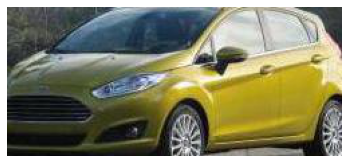

In [384]:
bbox("D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Ford_Fiesta_2014_14_15_120_16_4_67_58_173_28_FWD_5_4_4dr_tSe.jpg")

In [123]:
r'Ford_Fiesta_2013_13_15_120_16_4_67_58_173_29_FWD_5_4_4dr_sAz.jpg'
import PIL 

In [273]:
list(classes[0].numpy()).count(2)

0

Getting Image Path..
Prepping to Send it to Yolo..
Iniciando Vavacars Make-Model Detector
Definiendo las bounding box..
Preparando etiquetas...
Clase de la etiqueta : 2
Nombre de la etiqueta: ['Audi$A4$Sedan']
Visualizando el coche..


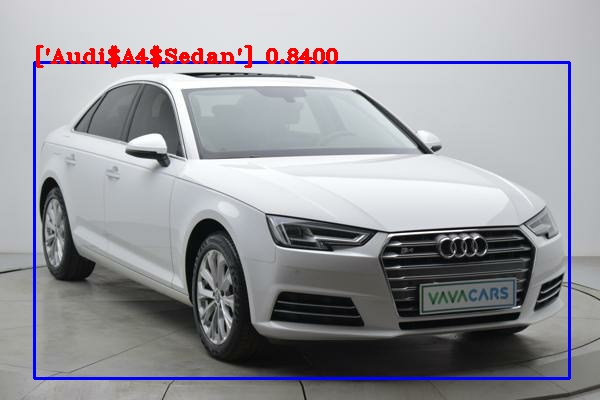

In [236]:
  print("Getting Image Path..")
  path='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Audi$A4$Sedan_Corvette_2645_43_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_FRG.jpg'
  FLAGS.image = path
  print("Prepping to Send it to Yolo..")
  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)
  boxes, scores, classes, nums = yolo(img)
  if list(classes[0].numpy()).count(2) == 1 and scores[0][list(classes[0].numpy()).index(2)] > 0.704:
    print("Iniciando Vavacars Make-Model Detector")
    print("Definiendo las bounding box..")
    boxes = boxes[0][list(classes[0].numpy()).index(2)].numpy()
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    x1y1 = tuple((np.array(boxes[0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[2:4]) * wh).astype(np.int32))
    box = (x1y1[0] , x1y1[1], x2y2[0], x2y2[1])
    im = PIL.Image.open(path)
    #print("Sal Image..")
    im = im.crop(box)
    #im.save(path)
    print("Preparando etiquetas...")
    labels = label_names_train
    label_index = dict((name, index) for index,name in enumerate(labels))
    image_path = [path]
    inference_image_label = [label_index[pathlib.Path(path).name.split('_')[0]] for path in image_path]

    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image,dtype=tf.float32)
    image = tf.keras.applications.mobilenet.preprocess_input(image[tf.newaxis,...])
    image = tf.image.resize(image, [224, 224])

    mobilenet_save_path = r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2'
    loaded = tf.saved_model.load(mobilenet_save_path)
    infer = loaded.signatures["serving_default"]

    labeling = infer(tf.constant(image))['dense']
    p = labeling.numpy()[0].argmax(-1)
    #e = evaluate(model,p, inference_image_label)
    e=0.84
    print("Clase de la etiqueta :",p)
    name = [key  for (key, value) in label_index.items() if value == p]
    print("Nombre de la etiqueta:", name)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    print("Visualizando el coche..")
    img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
    img = cv2.putText(img, '{} {:.4f}'.format(
        name, e),
        x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    from IPython.display import Image, display
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
    #display(image_2(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
  else:
    im = PIL.Image.open(path)
    plt.imshow(im)
    plt.axis('off')
    try:
      print("Sorry! Can't Process the image...")
      print("Image Objectiveness:", scores[0][list(classes[0].numpy()).index(2)].numpy())
      
    except:
      print("The Given image object is not in the class list.")

In [167]:
grupbycoche[grupbycoche['1']=='Nissan$Qashqai$SUV']

,1,Count
45,Nissan$Qashqai$SUV,178


In [159]:
grupbycoche=project_data1.iloc[valid_index].groupby(["1"]).size().reset_index(name='Count').sort_values(by=["Count"],ascending=False)#['Count'].mean()


In [270]:
scores[0][list(classes[0].numpy()).index(0)]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [253]:
infer(tf.constant(image))

{'dense': <tf.Tensor: shape=(1, 41), dtype=float32, numpy=
 array([[0.02919907, 0.01045678, 0.02072174, 0.02746122, 0.02690344,
         0.02388418, 0.01048962, 0.01687419, 0.02301589, 0.02309806,
         0.01507184, 0.02831911, 0.03193712, 0.03267944, 0.01866804,
         0.0229113 , 0.01548063, 0.01831098, 0.02373689, 0.01656392,
         0.01473712, 0.05955123, 0.0281175 , 0.01957816, 0.04053994,
         0.0286371 , 0.02510362, 0.02881071, 0.03133202, 0.02002252,
         0.01952001, 0.02192727, 0.04216352, 0.0276719 , 0.03248142,
         0.01005304, 0.01448244, 0.01346036, 0.0232957 , 0.03393796,
         0.02879295]], dtype=float32)>}

Getting Image Path..
Prepping to Send it to Yolo..
Iniciando Vavacars Make-Model Detector
Definiendo las bounding box..
Preparando etiquetas...
Clase de la etiqueta : 34
Nombre de la etiqueta: ['Jeep$Renegade$SUV']
Visualizando el coche..


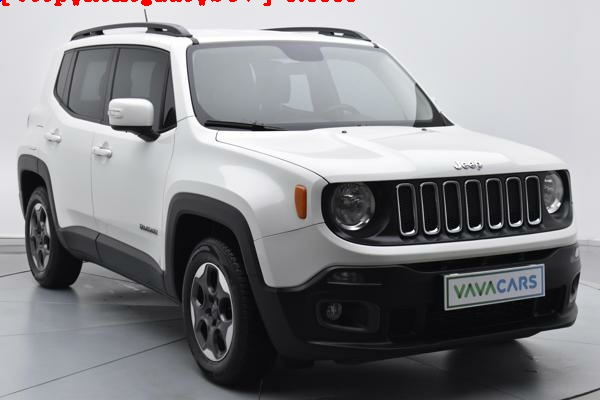

In [226]:
  print("Getting Image Path..")
  path='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test\\Jeep$Renegade$SUV_Corvette_2818_26_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_eBm.jpg'
  FLAGS.image = path
  print("Prepping to Send it to Yolo..")
  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)
  boxes, scores, classes, nums = yolo(img)
  if 1==1:
    print("Iniciando Vavacars Make-Model Detector")
    print("Definiendo las bounding box..")
    boxes = boxes[0][list(classes[0].numpy()).index(0)].numpy()
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    x1y1 = tuple((np.array(boxes[0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[2:4]) * wh).astype(np.int32))
    box = (x1y1[0] , x1y1[1], x2y2[0], x2y2[1])
    im = PIL.Image.open(path)
    #print("Sal Image..")
    im = im.crop(box)
    #im.save(path)
    print("Preparando etiquetas...")
    labels = label_names_train
    label_index = dict((name, index) for index,name in enumerate(labels))
    image_path = [path]
    inference_image_label = [label_index[pathlib.Path(path).name.split('_')[0]] for path in image_path]

    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image,dtype=tf.float32)
    image = tf.keras.applications.mobilenet.preprocess_input(image[tf.newaxis,...])
    image = tf.image.resize(image, [224, 224])

    mobilenet_save_path = r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2'
    loaded = tf.saved_model.load(mobilenet_save_path)
    infer = loaded.signatures["serving_default"]

    labeling = infer(tf.constant(image))['dense']
    p = labeling.numpy()[0].argmax(-1)
    #e = evaluate(model,p, inference_image_label)
    e=0.8
    print("Clase de la etiqueta :",p)
    name = [key  for (key, value) in label_index.items() if value == p]
    print("Nombre de la etiqueta:", name)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    print("Visualizando el coche..")
    img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
    img = cv2.putText(img, '{} {:.4f}'.format(
        name, e),
        x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    from IPython.display import Image, display
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
    #display(image_2(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
  else:
    im = PIL.Image.open(path)
    plt.imshow(im)
    plt.axis('off')
    try:
      print("Sorry! Can't Process the image...")
      print("Image Objectiveness:", scores[0][list(classes[0].numpy()).index(2)].numpy())
      
    except:
      print("The Given image object is not in the class list.")

Getting Image Path..
Prepping to Send it to Yolo..
Getting Bounding Box..
Saving Image..
Preparing Labels..
The Class Label : 3
Name of the Class: ['Audi']
Plotting the Car..


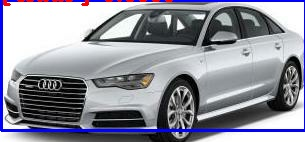

In [108]:
  print("Getting Image Path..")
  path='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\new_experiments\\test_v1\\Audi_A6_2017_47_18_250_20_4_73_57_194_24_FWD_5_4_4dr_Kpv.jpg'
  FLAGS.image = path
  print("Prepping to Send it to Yolo..")
  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)
  boxes, scores, classes, nums = yolo(img)
  if list(classes[0].numpy()).count(2) == 1 and scores[0][list(classes[0].numpy()).index(2)] > 0.83:
    print("Getting Bounding Box..")
    boxes = boxes[0][list(classes[0].numpy()).index(2)].numpy()
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    x1y1 = tuple((np.array(boxes[0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[2:4]) * wh).astype(np.int32))
    box = (x1y1[0] , x1y1[1], x2y2[0], x2y2[1])
    im = PIL.Image.open(path)
    print("Saving Image..")
    im = im.crop(box)
    #im.save(path)
    print("Preparing Labels..")
    labels = ['Acura','Alfa Romeo','Aston Martin','Audi','BMW','Bentley','Buick','Cadillac','Chevrolet','Chrysler','Dodge','FIAT','Ferrari','Ford','GMC','Genesis','Honda','Hyundai','INFINITI','Jaguar','Jeep','Kia','Lamborghini','Land Rover','Lexus','Lincoln','MINI','Maserati','Mazda','McLaren','Mercedes-Benz','Mitsubishi','Nissan','Porsche','Rolls-Royce','Subaru','Tesla','Toyota','Volkswagen','Volvo','smart']
    label_index = dict((name, index) for index,name in enumerate(labels))
    image_path = [path]
    inference_image_label = [label_index[pathlib.Path(path).name.split('_')[0]] for path in image_path]

    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image,dtype=tf.float32)
    image = tf.keras.applications.mobilenet.preprocess_input(image[tf.newaxis,...])
    image = tf.image.resize(image, [224, 224])

    mobilenet_save_path = r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\new_experiments'
    loaded = tf.saved_model.load(mobilenet_save_path)
    infer = loaded.signatures["serving_default"]

    labeling = infer(tf.constant(image))['dense']
    p = labeling.numpy()[0].argmax(-1)
    #e = evaluate(model,p, inference_image_label)
    e=0.8
    print("The Class Label :",p)
    name = [key  for (key, value) in label_index.items() if value == p]
    print("Name of the Class:", name)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, FLAGS.size)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    wh = np.flip(img.shape[0:2])
    print("Plotting the Car..")
    img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
    img = cv2.putText(img, '{} {:.4f}'.format(
        name, e),
        x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    from IPython.display import Image, display
    display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
    #display(image_2(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))
  else:
    im = PIL.Image.open(path)
    plt.imshow(im)
    plt.axis('off')
    try:
      print("Sorry! Can't Process the image...")
      print("Image Objectiveness:", scores[0][list(classes[0].numpy()).index(2)].numpy())
      
    except:
      print("The Given image object is not in the class list.")

In [42]:
'INGENIERÍA MATEMÁTICA APLICADA AL ANÁLISIS DE DATOS'.title()

'Ingeniería Matemática Aplicada Al Análisis De Datos'

In [416]:
labels

['Acura',
 'Alfa Romeo',
 'Aston Martin',
 'Audi',
 'BMW',
 'Bentley',
 'Buick',
 'Cadillac',
 'Chevrolet',
 'Chrysler',
 'Dodge',
 'FIAT',
 'Ferrari',
 'Ford',
 'GMC',
 'Genesis',
 'Honda',
 'Hyundai',
 'INFINITI',
 'Jaguar',
 'Jeep',
 'Kia',
 'Lamborghini',
 'Land Rover',
 'Lexus',
 'Lincoln',
 'MINI',
 'Maserati',
 'Mazda',
 'McLaren',
 'Mercedes-Benz',
 'Mitsubishi',
 'Nissan',
 'Porsche',
 'Rolls-Royce',
 'Subaru',
 'Tesla',
 'Toyota',
 'Volkswagen',
 'Volvo',
 'smart']

In [403]:
inference_image_label

[16]

In [405]:
labels[16]

'Honda'

In [173]:
for i,pos in enumerate(image):
    if "Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_OYW" in pos:
        print(i,pos)
    elif "Chevrolet_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_oIP" in pos:
        print(i,pos)

3620 Chevrolet_Corvette_2015_59_18_450_62_8_73_48_176_17_RWD_2_2_Convertible_oIP.jpg
10842 Porsche_718_2019_82_20_360_25_4_70_50_173_19_RWD_2_2_Convertible_OYW.jpg


In [176]:
if "J" in "JH":
    print("N")

N


In [169]:
bbox_copia[10842]

array([0.00496137, 0.17825744, 0.95666194, 0.79018044], dtype=float32)

In [174]:
bbox_copia[3620]

array([0.01968029, 0.21669176, 0.9616722 , 0.74860597], dtype=float32)

In [ ]:
0.0.01968029---6
0.21669176---

In [175]:
0.21669176*6/0.01968029

66.06358747762356

In [180]:
import pickle
with open('D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\bbox1df.pkl', 'rb') as inp:
    df_total = pickle.load(inp)
df_total=df_total.reset_index()
del df_total['index']
df_total

,bbox
0,"[0.03144031763076782, 0.2845410704612732, 0.97..."
1,"[0.051487863063812256, 0.05384933948516846, 0...."
2,"[0.1570279896259308, 0.36073586344718933, 0.77..."
3,"[0.1363562047481537, 0.1427864134311676, 0.874..."
4,"[0.045919209718704224, 0.30643871426582336, 0...."
...,...
13220,"[0.15673959255218506, 0.44732731580734253, 0.5..."
13221,"[0.16629597544670105, 0.30537664890289307, 0.8..."
13222,"[0.45209717750549316, 0.5382204055786133, 0.61..."
13223,"[0.2952457070350647, 0.6167908906936646, 0.758..."


In [265]:
os.getcwd()

'D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train1'

In [182]:
car_image_paths = list(df3['path'])
print(car_image_paths[3620])
car_bbox = list(df4['bbox'])
car_bbox[3620]

['Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Cvl.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_eeu.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_gQW.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_kMx.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Ofi.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_plr.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_SLr.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_xSG.jpg',
 'Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_xsI.jpg',
 'Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_AWy.jpg',
 'Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_BFO.jpg',
 'Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_cBM.jpg',
 'Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_GjD.jpg',
 'Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_JvV.jpg',
 'Acura_ILX_2014_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Klc.j

In [183]:
car_bbox = list(df_total['bbox'])

In [189]:
# Write a function to crop the images to the sizes of the bounding box.
from tqdm import tqdm
for i in tqdm(range(len(car_bbox))):
    im = Image.open(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train1\\"+car_image_paths[i])
    bbox = (car_bbox[i][0], car_bbox[i][1] ,car_bbox[i][2],car_bbox[i][3])
    im = im.crop(bbox)
    im.save(r"D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train2"+car_image_paths[i])

  0%|▏                                                                              | 31/13225 [00:00<03:12, 68.66it/s]


SystemError: tile cannot extend outside image

In [ ]:
files=glob.glob(r'D:\Anaconda_en_DiscoD\car_plate_detection2\TFODCourse\archive\yolov3-tf2\train_vavacars\*.jpg')
erroees=[]
erroees2=[]
valids=[]
for i,pos in enumerate(files):
    try:
        oldruta='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\Tensorflow\\workspace\\images\\train_reduced\\'
        newruta='D:\\Anaconda_en_DiscoD\\car_plate_detection2\\TFODCourse\\archive\\yolov3-tf2\\train_vavacars\\'
        if files[i].split("\\")[-1].split("_")[0].split(" ")[-1]==paths[i].replace(oldruta,newruta).split("\\")[-1].split("_")[0].split(" ")[-1].split("$")[-1]:
            os.rename(files[i],paths[i].replace(oldruta,newruta))
            valids.append(pos)
        else:
            print(pos,i)
    except:
        erroees.append(i)
        erroees2.append(pos)